# Исследование о продаже игр и закономерностях, определяющих успешность игры

### Общая информация

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import sweetviz as sv
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

In [9]:
data = pd.read_csv('/datasets/games.csv')

In [10]:
profile = ProfileReport(data, title='Pandas Profiling Report')

In [3]:
data.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
6497,Hatsune Miku: Project Diva,PSP,2009.0,Misc,0.00,0.00,0.26,0.00,NaN,NaN,NaN
6051,Puzzle Quest: Challenge of the Warlords,Wii,2007.0,Puzzle,0.26,0.00,0.00,0.02,71.0,6.2,E10+
6222,Pokemon Box: Ruby & Sapphire,GC,2003.0,Misc,0.00,0.00,0.27,0.01,NaN,NaN,NaN
15871,Army Men: Major Malfunction,XB,2006.0,Shooter,0.01,0.00,0.00,0.00,36.0,4,T
8029,AirForce Delta Storm,XB,2001.0,Shooter,0.14,0.04,0.00,0.01,61.0,7.1,E


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


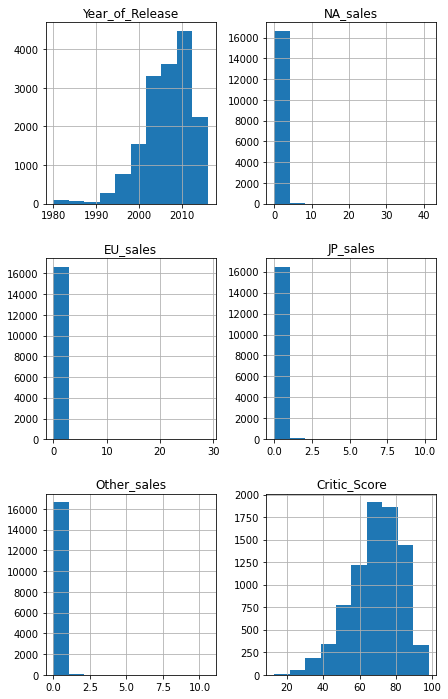

In [5]:
data.hist(figsize = (7, 12)); #построим гистограммы

In [6]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [7]:
data.duplicated().sum()

0

В датафрейме представлены данные за 1980-2016 гг. о продажах игр, оценках пользователей и экспертов, жанрах и платформах. В исходных данных всего 16715 строк и 11 столбцов:
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Пропущены данные в 6 столбцах - Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating. При этом в столбцах Name, Year_of_Release, Genre пропущено незначительное количество значений.
Также некорректно указаны типы данных в колонках Year_of_Release, User_Score. Дублирующих строчек нет.

### Предобработка данных

Для удобства приведем названия столбцов к нижнему регистру

In [8]:
data.columns = data.columns.str.lower()

In [9]:
data.isna().sum() # рассмотрим пропуски

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [10]:
data['name'].unique() # название игры

array(['Wii Sports', 'Super Mario Bros.', 'Mario Kart Wii', ...,
       'Woody Woodpecker in Crazy Castle 5', 'LMA Manager 2007',
       'Haitaka no Psychedelica'], dtype=object)

In [11]:
data.query('name.isna()') # посмотрим на пропущенные значения

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Так как в этих двух строках пропущены не только названия игр, но и жанр, а также их количество мало, удалим данные строки. Пропуски в названии игр и жанров могут возникать, потому что игра еще была в разработке и название не было придумано или же название и жанр не указали из-за ошибки.

In [12]:
data = data.drop(data.query('name.isna()').index)

In [13]:
data['platform'].unique() # платформа

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [14]:
data['year_of_release'].unique() # год выпуска

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

In [15]:
data[data['year_of_release'].isna()]  # выведем пропущенные значения в столбце "Год выпуска"

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Пропущенные значения в столбце "год выпуска" могли возникнуть из-за того, что дату забыли указать или же нет точной даты выхода.  Невозможно предположить по имеющимся данным год выпуска игры, так как на каждой платформе может быть разный год выпуска игры. Так как пропущенных значений меньше 2% от общего количества данных, удалим их.

In [16]:
data=data.dropna(subset = ['year_of_release']) # удалим пропущенные значения

In [17]:
data['year_of_release'] = data['year_of_release'].astype('int') # переименуем тим данных на целочисленный

In [18]:
data['genre'].unique() # жанг игры

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [19]:
data['na_sales'].value_counts() # продажи в Северной Америке (миллионы проданных копий)

0.00     4449
0.02      562
0.03      554
0.04      543
0.05      536
         ... 
14.44       1
13.96       1
2.35        1
2.96        1
4.40        1
Name: na_sales, Length: 401, dtype: int64

In [20]:
data['eu_sales'].value_counts() # продажи в Европе (миллионы проданных копий)

0.00    5766
0.01    1467
0.02    1290
0.03     911
0.04     702
        ... 
9.14       1
1.92       1
3.86       1
2.59       1
3.87       1
Name: eu_sales, Length: 307, dtype: int64

In [21]:
data['jp_sales'].value_counts() # продажи в Японии (миллионы проданных копий)

0.00    10300
0.02      733
0.01      697
0.03      540
0.04      391
        ...  
3.84        1
1.17        1
3.03        1
2.66        1
1.71        1
Name: jp_sales, Length: 244, dtype: int64

In [22]:
data['other_sales'].value_counts() # продажи в других странах (миллионы проданных копий)

0.00    6492
0.01    3398
0.02    1596
0.03     910
0.04     641
        ... 
0.72       1
2.11       1
0.96       1
1.48       1
3.96       1
Name: other_sales, Length: 155, dtype: int64

In [23]:
data['critic_score'].unique() # оценка критиков (максимум 100)

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [24]:
data['user_score'].unique() # оценка пользователей (максимум 10)

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Заметим, что в столбце "Оценка пользователей" значение 'tbd'. Такое значение указывается, когда пользователье еще не играл определенное количество игр и не выставил оценку. Заменим эти значения на Nan и поменяем тим данных на десятичный.

In [25]:
data['user_score'] = data['user_score'].replace('tbd', np.nan, regex=True).astype('float')

In [26]:
data['rating'].value_counts()  # рейтинг от организации ESRB

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64

При просмотре рейтингов обратим внимание на К-А, это устаревшая абревиатура, необходимо переименовать на Е. Для большего понимания создадим новый столбец, где функцией подробнее распишем информацию по рейтингу. Пропущенные значения заменим на "не определен", так как рейтинг может быть еще не выставлен или же игра могла не выпускаться, где выдается данный рейтинг.

In [27]:
# функция для расшифровки рейтинга
def full_rating(name):
    try:
        if name == 'E' or name == 'K-A':
            return 'для всех возрастов'
        elif name == 'T':
            return 'от 13 лет'
        elif name == 'M':
            return 'от 17 лет'
        elif name == 'RP':
            return 'рейтинг ожидается'
        elif name == 'AO':
            return 'от 18 лет'
        elif name == 'E10+':
            return 'от 10 лет'
        elif name == 'EC':
            return 'от 3 лет'
        else:
            return 'не определен'
    except:
        pass

In [28]:
data['full_rating'] = data['rating'].apply(full_rating)

In [29]:
data['full_rating'].value_counts() # рейтинг

не определен          6676
для всех возрастов    3924
от 13 лет             2905
от 17 лет             1536
от 10 лет             1393
от 3 лет                 8
рейтинг ожидается        1
от 18 лет                1
Name: full_rating, dtype: int64

In [30]:
data.info() # пропущенные значений после обработки

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
 11  full_rating      16444 non-null  object 
dtypes: float64(6), int64(1), object(5)
memory usage: 1.6+ MB


Пропущенные значения в столбцах "critic_score", "user_score" оставим без изменений, так как игры могли быть новыми и критики и пользователи могли еще не оценить их.

Посчитаем суммарные продажи по всем регионам:

In [31]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

Таким образом, при предобработке данных были удалены пропущенные значения в столбцах "Наименование игры", "Жанр", "Год выпуска", количество удаленных значений составляет меньше 2%. Изменен тип данных в столбцах "Год выпуска", "Оценка пользователей". Также в столбце "Оценка пользователей" было заменено значение 'tbd' на NaN, так как это значение возникает, когда пользователей не сыграл определенное количество игр для возможности поставить оценку. Создан новые столбцы: "full rating" для понятной расшифровки рейтинга, заменены устаревшее значение рейтинга и пропущенные значения, "total_sales" - суммарные продажи по всем регионам.

### Исследовательский анализ данных

#### Количество выпущенных игр в каждом году

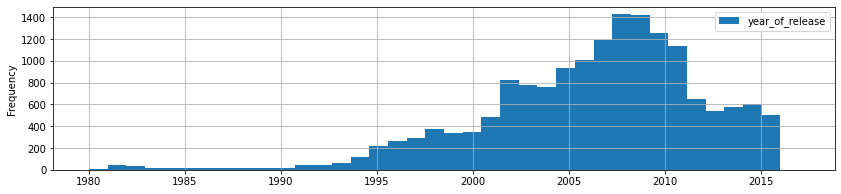

In [32]:
# рассмотрим, сколько игр выпускалось в каждом году
data.plot(y = 'year_of_release', kind = 'hist', bins = 38, grid=True, figsize = (14,3), range = (1980,2017));

На графике видно, что пик на выпуск игр приходится на 2009-2010 гг., хотя в 2007-2008 гг. в банковской сфере произошел кризис, который по принципу "домино" потянул за собой другие сектора, в том числе и игровую индустрию. Игровая индустрия пострадала гораздо меньше других, ведь в сложившемся положении игры оставались одним из самых доступных видов досуга. 2012-2013 гг. были самыми тяжелыми для розничных продаж, по графику наблюдается резкий спад, в 2012 году New-York Times писала, что игры становятся для американцев дорогим развлечением и для многих проще раз в месяц покупать подписку по цене билета в кино на одну единственную игру, чем тратить по 60 долларов хотя бы раз в месяц.  С 2012-2016 гг. по графику наблюдается застой. 
За все время данные нам не важны, возьмем данные, начиная с 2013 года.

#### Продажи по платформам

In [33]:
# посмотрим как менялись продажи по платформам
platform_pivot=data.pivot_table(index=['platform'], values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)

In [34]:
platform_pivot

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Таким образом, платформы с наилучшими суммарными продажами - PS2, X360, PS3, Wii, DS, PS.

In [35]:
# построим сводную таблицу с подсчетом сроков жизни платформ
years=data.pivot_table(index = 'platform', values='year_of_release', aggfunc=['min', 'max'])

In [36]:
years['dif']=years['max']-years['min'] # разница между максимальной датой выхода игры и минимальной

In [37]:
years=years.sort_values(by='dif', ascending=False) # сортировка по количеству лет

In [38]:
years

,min,max,dif
,year_of_release,year_of_release,
platform,,,
PC,1985,2016,31
DS,1985,2013,28
GB,1988,2001,13
X360,2005,2016,11
PSP,2004,2015,11
PS2,2000,2011,11
NES,1983,1994,11
DC,1998,2008,10


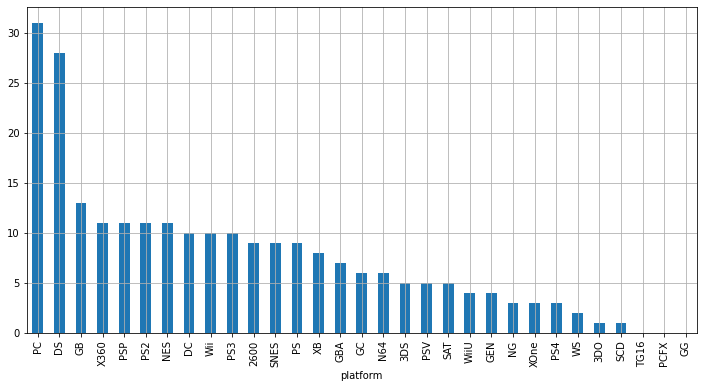

In [39]:
years['dif'].plot(kind='bar', figsize=(12, 6), grid=True); # для наглядности построим график для 6 лучших платформ

В среднем платформы живут 8-10 лет. Отметим две платформы - PC, DS, которые функционировали более 28 года. А  PC до сих пор еще функционирует и не собирается уходить с рынка. Заметим, что в промежуток с 1990-2000 гг. новые платформы появлялись практически каждый год, а, начиная с 2001 года в промежутке 4-5 лет.

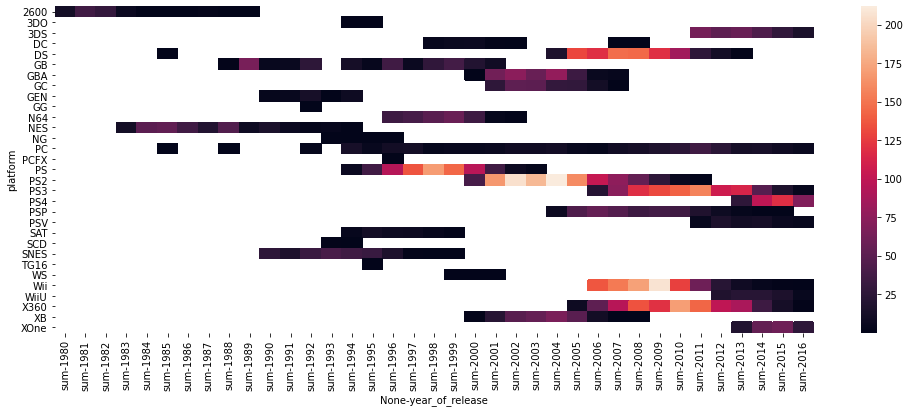

In [40]:
fig, ax = plt.subplots(figsize=(17, 6))
sns.heatmap(data.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc=['sum']));

**Для дальнейшего анализа возьмем данные за актуальный период - начиная с 2014 года, так как игровая индустрия - это динамично развивающая индустрия и брать слишком большой временной интервал некорректно.**

In [42]:
new_data=data.query('year_of_release>=2014')

#### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

In [43]:
# построим сводныу таблицу по общему количеству продаж по каждой платформе 
platform=new_data.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values(by='total_sales', ascending=False)

In [44]:
platform

,total_sales
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22
WiiU,42.98
PC,27.05
PSV,22.40
Wii,5.07


Начиная с 2014 года больше всего копий продаж по платформам PS4, XOne, 3DS, PS3, X360.

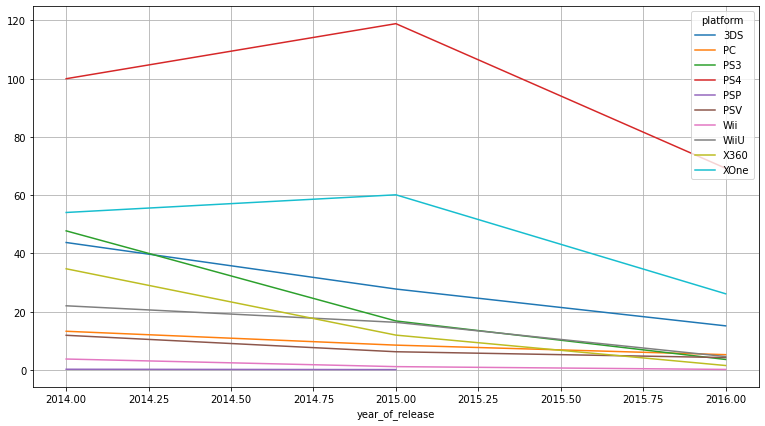

In [45]:
# построим график по продажам по всем платформам
platform = new_data.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum').plot(grid=True, figsize = (13,7));

По графику видно, что по всем платформам идет тренд на снижение количества продаж. Среди них, в последние годы больше всего продаж наблюдается на игры на PS4, так как эта платформа появилась достаточно недавно. PS4 является потенциально прибыльной платформой. Несмотря на то, что платформа XOne появилась в том же году, что и PS4, продожи по ней примернов 2 раза меньше, но эта платформа тоже является потенциально прибыльной. Платформа PC показывает небольшие, но стабильные продажи. Несмотря на то, что по платформе PSV продажи с момента внедрения не выросли как PS4, XOne, но все равно она показывает стабильные продажи.  Платформы PS3, Wii, X360 падают сильнее всего, при том, что за весь период это самые прибыльные платформы. На остальные платформы уже давно упал спрос или они вообще не продаются.

Таким образом, к потенциально прибыльным можно отнести  все сравнительно новые платформы - PS4, XOne, PC, PSV, 3DS, WiiU.
Потенциально убыточные - X360, PS360.

In [46]:
# построим график по потенциально прибыльным платформам
top_platform = new_data.query('platform==["PS4", "XOne", "PC", "PS3", "3DS", "WiiU"]')

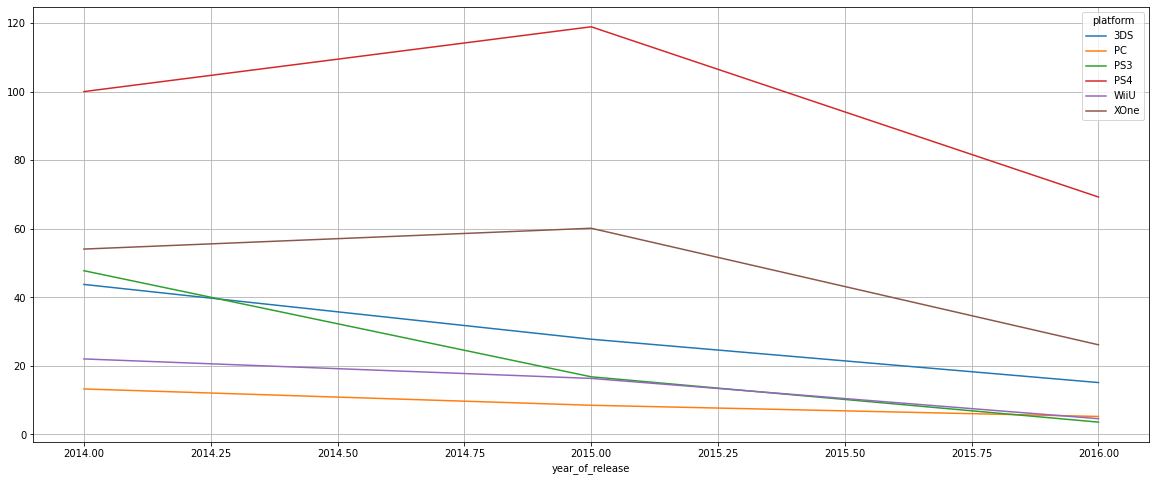

In [47]:
top_platform.pivot_table(index='year_of_release', columns = 'platform', values='total_sales', aggfunc='sum').plot(grid=True, figsize = (20,8));

Так как практически все эти платформы сравнительно новые, они являются потенциально прибыльными.

#### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

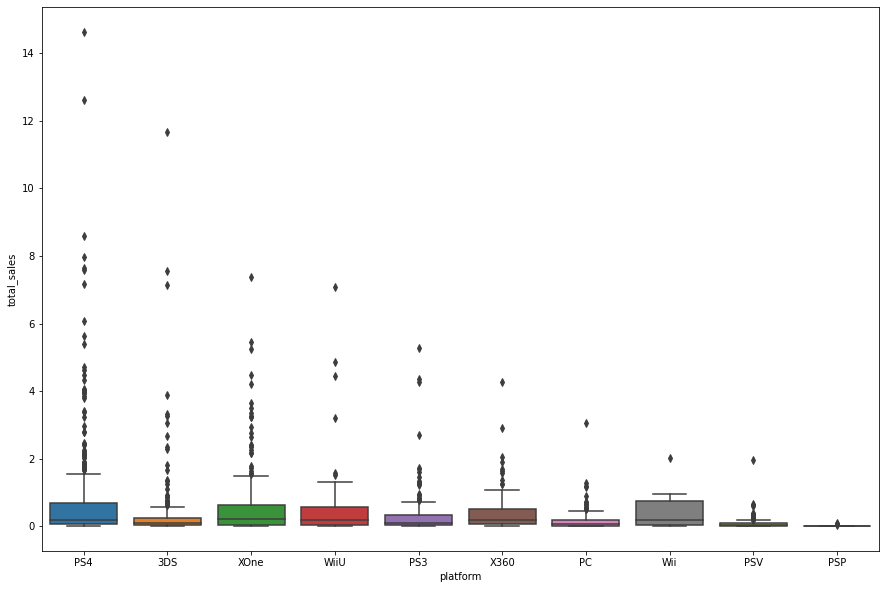

In [48]:
# постороим «ящик с усами» в разбивке по платформам
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(x='platform', y='total_sales', data=new_data, ax=ax);


По графику наблюдаются единичные выбросы в районе 10-15 млн на платформах PS4 и 3DS - достаточно современных платформах. Видимо игры на этих платформах были наиболее популярны. В районе 2-10 млн количество выбросов уже намного больше. Больше всего выбросов в этом диапозоне наблюдается на современных платформах - PS4, X360, 3DS - также можно считать, что игры на этих платформах достаточно популярны, на остальных выбросов меньше. Далее посмотрим на диаграмму размаха

(0.0, 1.6)

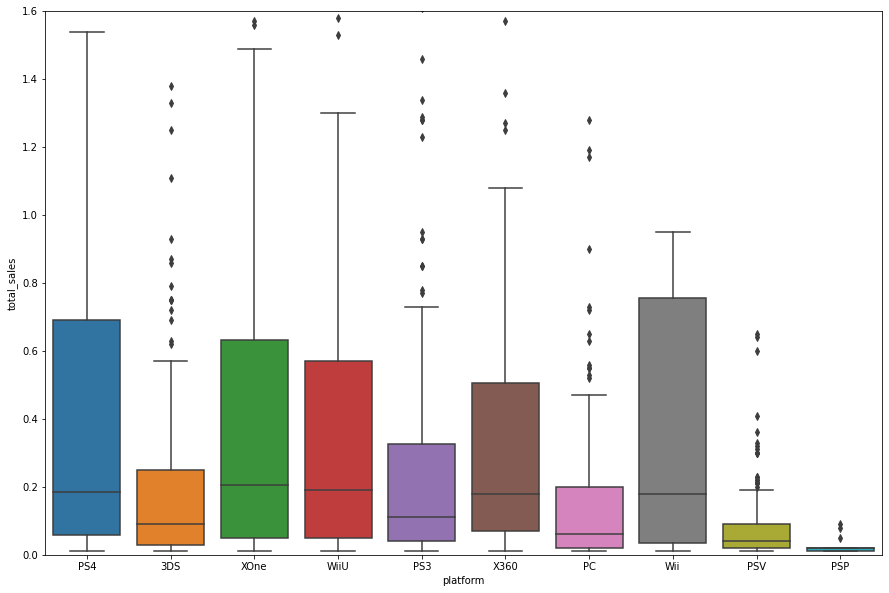

In [49]:
# постороим «ящик с усами» в разбивке по платформам
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(x='platform', y='total_sales', data=new_data, ax=ax);
plt.ylim(0, 1.6)

По данному графику заметим, распределение по всем платформам являются ассиметричны, медианы находятся ближе к нижнему квартилю, а также нижний ус находится намного ближе к 1-ому квартилю, что говорит о том, что  преобладают игры с небольшими продажами и небольшим числом мегапопулярных игр.  
Максимальный размах продаж копий видеоигр имеют платформы PS4, XOne и составляет примерно 1.4-1.5 млн. Стоит отметить, что 
что современные платформы XOne, WiiU, PS4 по медианному значению находятся практически на одном уровне с платформой Wii, что говорит о том, что игры на современных платформах покупают чаще. Хотя по суммарным продажам платформа Wii находится не на первом месте и из года в год продажи только падают, межквартильный размах у данной платформы самый большой.

#### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Для сравнения возьмем несколько платформ платформы: PS3, XOne, PS4, WiiU.

In [50]:
platform_corr=["PS3", "XOne", "PS4", "WiiU"]

In [51]:
def show_corr(name_of_platform):
    platform = new_data[new_data['platform']==name_of_platform]
    fig, ax = plt.subplots(1 ,2, figsize=(15,5))
    sns.scatterplot(x='user_score', y='total_sales', data=platform, ax=ax[0])
    sns.scatterplot(x='critic_score', y='total_sales', data=platform, ax=ax[1])
    fig.suptitle(name_of_platform, fontsize=15)
    ax[0].set(xlabel='Оценка пользователей')
    ax[1].set(xlabel='Оценка критиков')
    ax[0].set(ylabel='Количество продаж')
    ax[1].set(ylabel='Количество продаж')
    plt.show()
    
    user_correl = platform['user_score'].corr(platform['total_sales'])
    critic_correl = platform['critic_score'].corr(platform['total_sales'])
    print('Корреляция между отзывами критиков и игровой платформой ', name_of_platform.upper(), critic_correl)
    print('Корреляция между отзывами пользователей и продажами ', name_of_platform.upper(), user_correl)

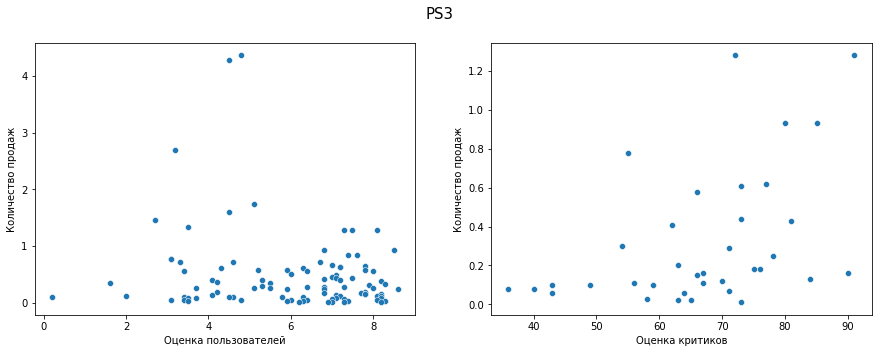

Корреляция между отзывами критиков и игровой платформой  PS3 0.44657460493190704
Корреляция между отзывами пользователей и продажами  PS3 -0.16676141347662118


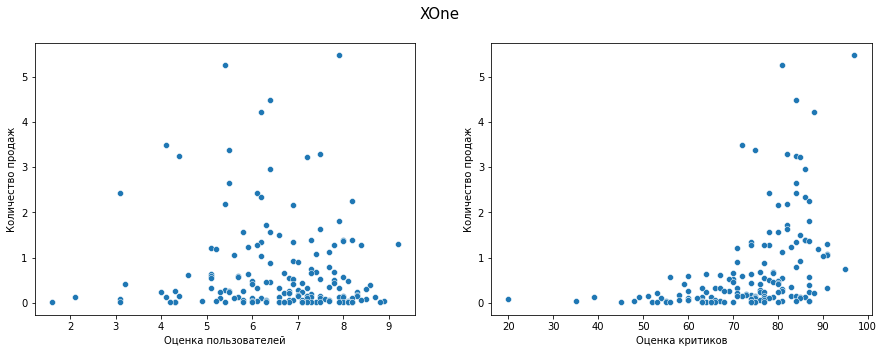

Корреляция между отзывами критиков и игровой платформой  XONE 0.42867694370333226
Корреляция между отзывами пользователей и продажами  XONE -0.0703839280647581


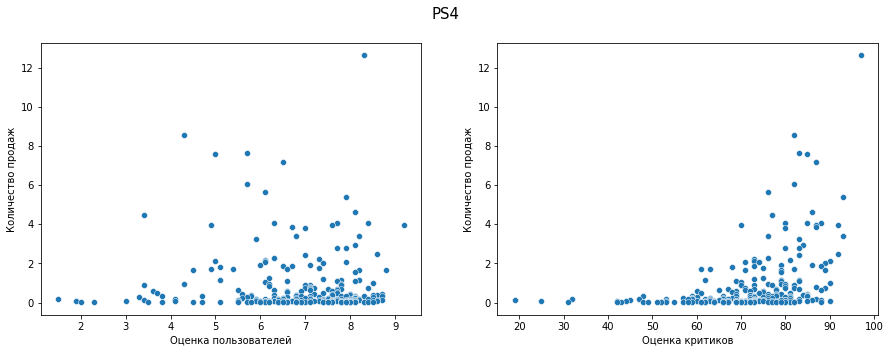

Корреляция между отзывами критиков и игровой платформой  PS4 0.40266141068104083
Корреляция между отзывами пользователей и продажами  PS4 -0.040131589472697356


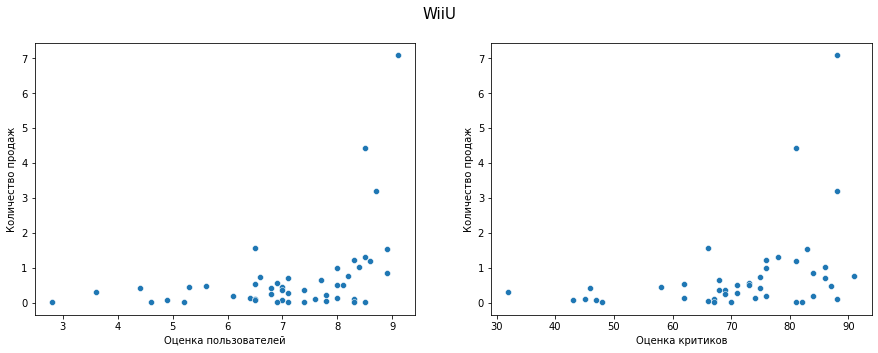

Корреляция между отзывами критиков и игровой платформой  WIIU 0.370201412480884
Корреляция между отзывами пользователей и продажами  WIIU 0.40792645792170773


In [52]:
for platform in platform_corr:
    show_corr(platform)

Между оценками критиков и общими продажами наблюдается умеренная положительная связь, между оценками пользователей и общими продажами взаимосвязь практически не наблюдается и везде она слабая отрицательная кроме платформы WiiU. В нашем случае это единственная платформа, где взаимосвязь между оценкой пользователей и продажами сильнее чем между оценками критиков. Но так как корреляция Пирсона выявляет только линейную связь, нельзя утверждать, что между оценкой пользователей и продажами связь отсутсвует совсем. На графиках с оценками пользователей на платформах XONE, PS4 наблюдается нелинейная связь и график больше похож на степенную функцию.

Корреляция продаж с отзывами критиков выше, так как критики оценивают игру более комплексно и в деталях. Они смотрят на игру в срезе ряда критериев: графика, геймплей, сюжет, техническая реализация, эмоции и так далее. Такой подход позволяет оценить игру более комплексно и менее субъективно. А пользователи оценивают игры опираясь на свои эмоции, что в свою очередь субъективно и не всегда взвешено.

Можно ли утверждать о причинно-следственной связях при высоких значениях корреляции?

Причинно-следственная связь всегда подразумевает наличие корреляции. Корреляция не обязательно означает наличие причинно-следственной связи. Корреляция может быть случайной, но причинно-следственная связь по определению не может быть случайностью.

Если корреляция есть, то для доказательства причинно-следственной связи должны соблюдаться еще два условия - отсутствие сторонних факторов, которые влияют на обе переменные; прямая временная последовательность между изменением первого и второго показателя.


Исходя из этого, можно сделать выводы, что на все платформы отзывы критиков влияют больше, чем отзывы пользователей

#### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [53]:
# построим сводную таблицу по жанрам
genre_data=new_data.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'mean']).sort_values(by=('sum', 'total_sales'), ascending=False)

In [54]:
genre_data

,sum,mean
,total_sales,total_sales
genre,,
Action,199.36,0.322068
Shooter,170.94,1.335469
Sports,109.48,0.680000
Role-Playing,101.44,0.459005
Misc,37.55,0.332301
Fighting,28.22,0.470333
Racing,27.52,0.398841
Platform,18.09,0.476053


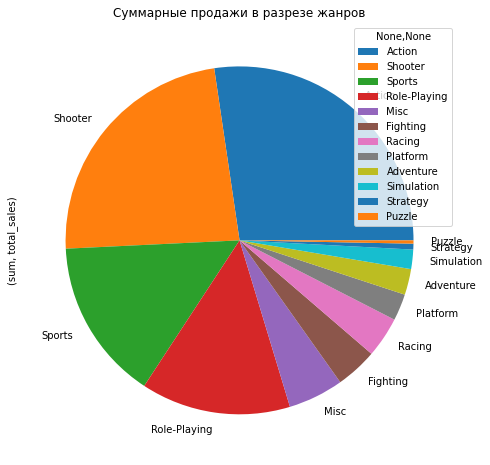

In [55]:
genre_data.plot(kind='pie', y=('sum', 'total_sales'), figsize=(8,8), title='Суммарные продажи в разрезе жанров');


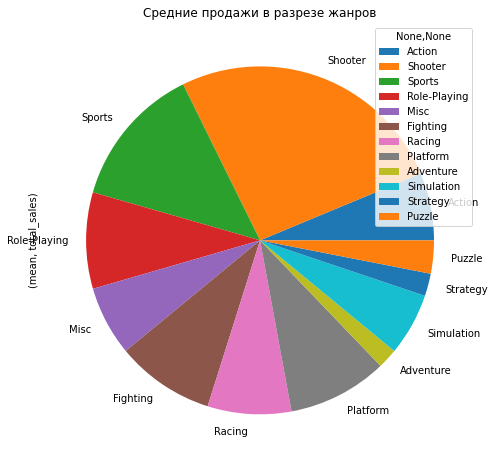

In [56]:
genre_data.plot(kind='pie', y=('mean', 'total_sales'), figsize=(8,8), title='Средние продажи в разрезе жанров');

Анализируя две диаграммы, можно сделать выводы, что по суммарным продажам самые популярные жанры - Action, Sports, Shooter. Наименее популярные жанры - Strategy, Puzzle.
По средним продажам самые популярные жанры - Shooter, Sports, Role-Playing. Наименее популярные - Adventure, Strategy. Соотношение немного поменялось. То есть, можно сказать, что за высокими продажами игр жанра Action может скрываться множество мелких игр с низкими продажами. 

### Портрет пользователя по каждому региону

Определите для пользователя каждого региона (NA, EU, JP):
Самые популярные платформы (топ-5). Опишите различия в долях продаж.
Самые популярные жанры (топ-5). Поясните разницу.
Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [57]:
def show_reg(tab):
    tab = tab.pivot_table(index=tab.columns[0], values=tab.columns[1],aggfunc=['sum']).sort_values(by=('sum', tab.columns[1]), ascending=False).plot(kind = 'bar', figsize=(12,4), grid=True);
    #plt.xlabel(tab.columns.values[0])
    plt.ylabel('Продажи экземпляров (млн.)')
    return tab;

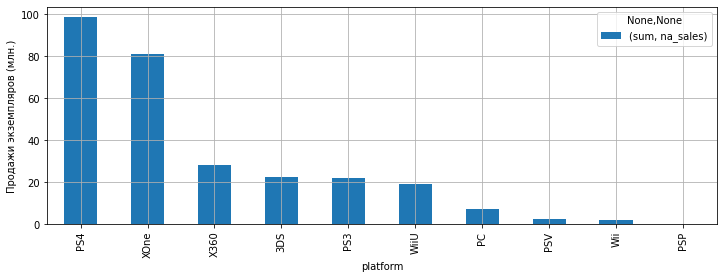

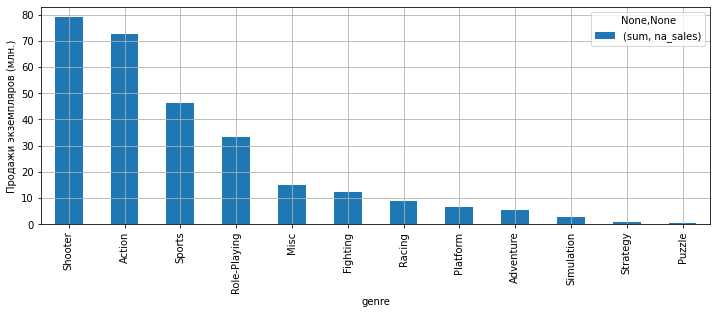

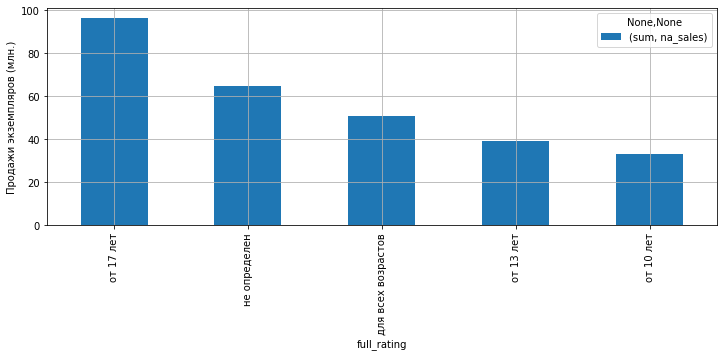

In [58]:
# продажи в Северной Америке
show_reg(new_data[['platform', 'na_sales']])
show_reg(new_data[['genre', 'na_sales']])
show_reg(new_data[['full_rating', 'na_sales']]);

Пользователи Северной Америки больше всего предпочитают PS4 - японскую консоль. Платформы XOne, X360 - пользуются также значительной популярностью, это американские консоли. В сумме продаж преобладают игры на американских консолях. Самые популярные жанры в Северной Америке - это Action, Sports, Shooter, Misc, Role-Playing. Больше всего преобладают игры от 17 лет. Так же большую долю занимает информация по неопределенному рейтингу, что тоже немаловажно учитывать, скорее всего, потому что ассоциация по рейтингу американская, а самая популярная платформа японская, поэтому рейтинг по японским играм не проставлен.

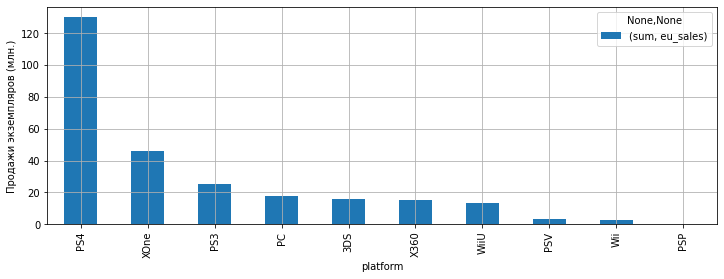

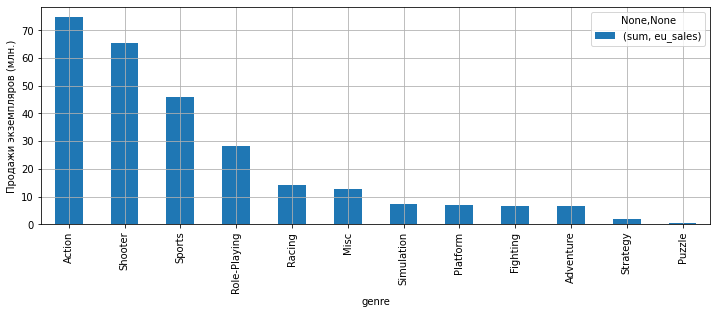

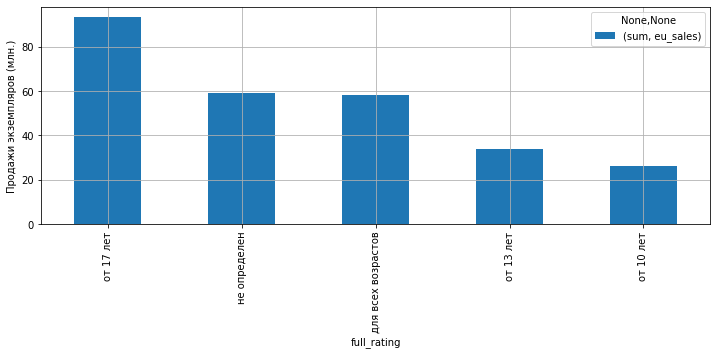

In [59]:
# продажи в Европе
show_reg(new_data[['platform', 'eu_sales']])
show_reg(new_data[['genre', 'eu_sales']])
show_reg(new_data[['full_rating', 'eu_sales']]);

У пользователей Европы популярны как американские платформы, так и японские. В целом запросы такие же как у пользователей из Северной Америки.

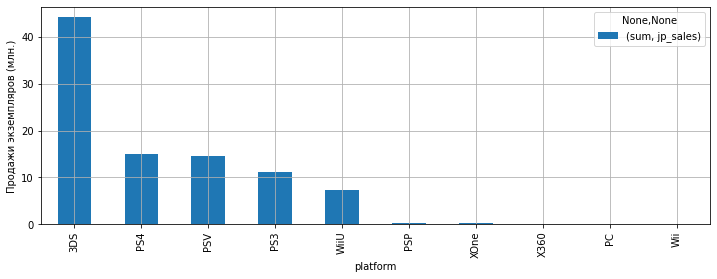

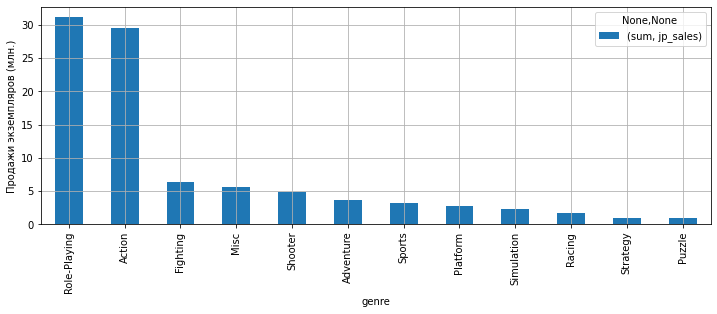

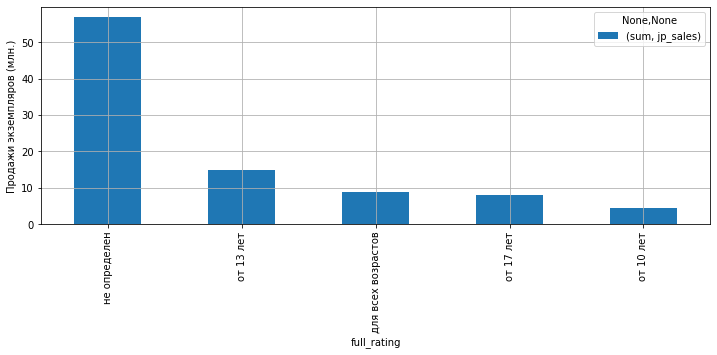

In [60]:
# продажи в Японии
show_reg(new_data[['platform', 'jp_sales']])
show_reg(new_data[['genre', 'jp_sales']])
show_reg(new_data[['full_rating', 'jp_sales']]);

Большинство японских пользователей играют в японские платформы, что неудивительно из-за большого разнообразия платформ, американские платформы преобладают в меньшей степени. При этом наибольшей популярностью пользуются портативные консоли, поэтому и самый популярный жанр игр - Role-playing. В большей степени в Японии преобладают игры с неопределенным рейтингом, скорее всего это связано, что рейтинг является американским и он не распространяется на игры в Японии.

**Вывод:**
В целом, вкусы на игры и жанры в Северной Америке и Европе схожи, там преобладают платформы американского производства, но и платформы японского производства занимают не последнее место. В Японии преобладают портативные платформы своей страны, поэтому и жанр игры отличается тем, что в эти игры можно играть вне дома. Больше всего покупок игр происходит с рейтингом "для всех возрастов", что, скорее всего, является определяющим фактором покупки игр. Стоит обратить внимание, что у подавляющего большинства игр не указан рейтин, это может быть связано с тем, что в данном датафрейме рассматривается рейтинг ESRB, а он не предоставляет рейтинг игр для Японии и других стран.

### Проверка гипотез

* Гипотеза 1: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [61]:
# посчитаем средние пользовательские рейтинги по двум платформам
XOne = new_data[(new_data['platform'] == 'XOne') &  (new_data['user_score'] > 0)]['user_score']
PC = new_data[(new_data['platform'] == 'PC') &  (new_data['user_score'] > 0)]['user_score']
print('Средний пользовательский рейтинги платформ Xbox One -', round(XOne.mean(), 2))
print('Средний пользовательский рейтинги платформ PC - ', round(PC.mean(), 2))

Средний пользовательский рейтинги платформ Xbox One - 6.59
Средний пользовательский рейтинги платформ PC -  6.3


Будем использовать двустороннюю гипотезу, так как проверяем утверждение "равно" или "не равно"
Сформируем нулевую и альтернативную гипотезу:

H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H1: Средние пользовательские рейтинги платформ Xbox One и PC разные
Для проверки гипотез будем использовать статестические методы.

In [62]:
alpha = .05
results = st.ttest_ind(XOne, PC, equal_var=False)
print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


Таким образом, Средние пользовательские рейтинги платформ Xbox One и PC статистически значимо не различаются

* Гипотеза 2: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Сформируем нулевую и альтернативную гипотезу:

H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые

H1: Средние пользовательские рейтинги жанров Action и Sports разные

In [63]:
# посчитаем средние пользовательские рейтинги по двум жанрам
Action = new_data[(new_data['genre'] == 'Action') &  (new_data['user_score'] > 0)]['user_score']
Sports = new_data[(new_data['genre'] == 'Sports') &  (new_data['user_score'] > 0)]['user_score']
print('Средний пользовательский рейтинги жагра Action -', round(Action.mean(), 2))
print('Средний пользовательский рейтинги жанра Sports - ', round(Sports.mean(), 2))

Средний пользовательский рейтинги жагра Action - 6.76
Средний пользовательский рейтинги жанра Sports -  5.23


In [64]:
alpha = .05
results = st.ttest_ind(Action, Sports, equal_var=False)
print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


Таким образом отвергаем нулевую гипотезу и делаем вывод, что средние пользовательские рейтинги жанров Action и Sports статестически значимо различаются.

### Общий вывод

**Работа с данными:**
По имеющимся данным был произведен анализ продаж видеоигр по годам и определены закономерности, определяющие успешность игр.
На начальном этапе была произведена предобработка данных - удалены пропущенные значения (менее 2%), изменены типы данных в столбцах, заменено значение в столбце "Оценка пользователей" 'tbd' на NaN, так как это значение возникает, когда пользователь не сыграл определенное количество игр для возможности поставить оценку, расшифрован рейтинг, в котором были заменены пропущенные значения, а также создан столбец суммарные продажи по всем регионам.

При анализе данных 1980-2016 гг. было выявлено, что самое большее количество игр продавалось в 2009-2010 гг., хотя  в это время бушевал кризис. Кризис же в игровой сфере произошел начиная с 2012 года, когда наблюдалось резкое снижение покупок игр. 
За весь период платформы с наилучшими суммарными продажами - PS2, X360, PS3, Wii, DS, PS. Было определено, что в среднем платформы живут 8-10 лет. А платформа PC до сих пор функционирует уже больше 30 лет. 
Для дальнейшего анализа были взяты данные с 2014 года, так как это динамично развивающая индустрия и брать слишком большой временной интервал некорректно.
За актуальный период больше всего копий продаж по платформам PS4, XOne, 3DS, PS3, X360.
По всем платформам идет тренд на снижение количества продаж. Среди них, в последние годы больше всего продаж наблюдается на игры на PS4, так как эта платформа появилась достаточно недавно. Несмотря на то, что платформа XOne появилась в том же году, что и PS4, продожи по ней примернов 2 раза меньше, но эта платформа тоже является потенциально прибыльной. Платформа PC показывает небольшие, но стабильные продажи.  Платформы PS3, Wii, X360 падают сильнее всего, при том, что за весь период это самые прибыльные платформы. На остальные платформы уже давно упал спрос или они вообще не продаются. 
Таким образом, к потенциально прибыльным можно отнести  все сравнительно новые платформы - PS4, XOne, PC, PS3, 3DS, WiiU.
Потенциально убыточные - X360, PS3.
Делаем вывод, что самые прибыльные платформы на будующий период - это достаточно новые платформы.

**Анализ корреляции:**
Связь между оценками критиков и продажими является умеренная положительная, а между оценками пользователей и общими продажами взаимосвязь практически не наблюдается.
Исходя из этого, можно сделать выводы, что на все платформы отзывы критиков влияют больше, чем отзывы пользователей, но здесь мы рассматриваем только линейную связь и сказать, что "связь между оценкой пользователей и продажами отсутсвует" мы не можем.

**Портрет пользователей разных стран:**
Самыми популярными жанрами являются Action, Sports, Shooter. Наименее популярные жанры - Strategy, Puzzle.
Что касается вкусов разных стран - вкусы на игры и жанры в Северной Америке и Европе схожи, там преобладают платформы как американского производства, так и японского. В Японии преобладают портативные платформы своей страны, поэтому и жанр игры отличается тем, что в эти игры можно играть вне дома. Больше всего покупок игр происходит с рейтингом "от 17 лет". Стоит обратить внимание, что у подавляющего большинства игр не указан рейтин, это может быть связано с тем, что в данных рассматривается рейтинг ESRB, а он не предоставляет рейтинг игр для Японии.

**Проверка гипотез:**
Были проверены две гипотезы:
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
И первая и вторая гипотезы подтвердились.

**Критерии успешности игры:**
К критериям, определяющим успешность игры можно отнести регион продаж, рейтинг ассоциации, платформа, жанр и рейтинг критиков.

Игры, которые будут продаваться в Северной Америке лучше всего:
Рейтинг ассоциации - "для всех возрастов", "от 17 лет", "от 13 лет"
Платформы: Xbox360, PS4, PS3, 3DS
Жанры: Action, Sports, Shooter, Misc, Role-Playing

Игры, которые будут продаваться в Европе лучше всего:
ESRB: "для всех возрастов", "от 17 лет", "от 13 лет"
Платформы: PS4, XOne, PS3, 3DS
Жанры: Action, Sports, Shooter, Misc, Racing

Игры, которые будут продаваться в Японии лучше всего:
ESRB: "для всех возрастов", "от 17 лет", "от 13 лет" (стоит учитывать, что большинство игр ассоциация ESRB в Японии не проставляет)
Платформы: 3DS, PS4, PSV, PS3
Жанры: Role-Playing, Action, Misc, Sports, Platform

